# Clustering of Toronto Neighbourhoods

The aim of this notebook is to attempt to divide the neighbourhoods (or rather, postal codes) of Toronto into different clusters based on the type of establishments in the area.

We have a list of toronto postal codes along with their geospatial coordinates (data sources explained in previous sections). We will now obtain a list of establishments in a certain radius around each coordinate using the Foursquare API.

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix

import requests
import os # Used to retrieve API keys from environment variables

import folium
from matplotlib import cm
from matplotlib import colors

## Import Data

First, we import the data from the CSV file created earlier.

In [2]:
df = pd.read_csv('../data/toronto_coordinates_merged.csv')
df.set_index('Postal Code', inplace=True) # Set Postal Code as the index
df.head()

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## Data Exploration

We will segment Toronto on the basis of postal codes rather than the neighbourhood names, since we have this geospatial data available, and it serves the same purpose.

First, we need to select a suitable radius to search around each coordinate. Our aim is to cover as much of Toronto's area as possible while minimizing the overlap between each neighbourhood.

Circles of vari=ying radius can be plotted using folium and we can select a good value by visually studying the output.

In [3]:
# Create map centred on Toronto
map_centre = [43.715383, -79.405678]
toronto_map = folium.Map(location=map_centre, zoom_start=11)

search_radius = 500 # Radius in metres

# Draw circles at each location is dataframe
for latitude, longitude, postal_code, neigh in zip(df['Latitude'], df['Longitude'], df.index, df['Neighbourhood']):
    folium.Circle(
        [latitude, longitude],
        radius = search_radius,
        popup = postal_code + ' - ' + neigh,
        fill = False,
        color = 'red',
    ).add_to(toronto_map)

toronto_map # View map

Although most of the circles are spaced fairly wide apart, there is a section in the southern part of the city which has an unusually high concentration of postal codes. This causes some overlapping and is likely to create inaccurracies while clustering - since many of the establishments returned by Foursquare will be the same for these postcodes, they will show up as very similar during clustering.

Looking at the points in question, some of these also appear to be special codes assigned to specific addresses - perhaps goverment or other institutions. They are therefore not really relevant and should be removed.

To remedy this, we will try to filter out some of the postal codes that are too close to others. For this, Scipy's distance_matrix method is used. We will create a function for this calculation, since we need to repeat it multiple times.

In [4]:
def calc_nearest(lat, lng, label):
    '''
    Calculates the minimum distance between a set of geospatial coordinates.

    Parameters:
    lat (list)   : Latitude data
    lng (list)   : Longitude data
    label (list) : Labels (eg. Postal Code)

    Returns:
    Three values as a list
    min_dist (float) : Minimum distance between any pair of points
    label1 (str)     : Label of the first point in the pair
    label2 (str)     : Label of the second point in the pair
    '''

    
    coord_list = np.column_stack((lat, lng)) # Create array of geospatial coordinates
    coord_distances = distance_matrix(coord_list, coord_list)
    np.fill_diagonal(coord_distances, np.inf) # Replace diagonal with infinity, so does not affect minimum distance

    # Create a pandas dataframe from the distances
    df_distances = pd.DataFrame(coord_distances,index=label, columns=label)

    # Find minimum distances and respective postal codes
    minvalues = pd.DataFrame(df_distances.idxmin(axis=0), columns=['Nearest'])
    minvalues['Distance'] = df_distances.min(axis=0)

    # Save minimum point labels (both row and column name) and distance to a list
    min_dist = minvalues['Distance'].min()
    label1 = minvalues['Distance'].idxmin()
    label2 = minvalues.loc[label1]['Nearest']

    return min_dist, label1, label2

test_dist, test_lat, test_lng = calc_nearest(df['Latitude'], df['Longitude'], df.index)
print('The minimum distance {} is between {} and {}'.format(test_dist, test_lat, test_lng))

The minimum distance 0.001436607183613256 is between M5K and M5X


We see that M5X and M5K are the closest together, which matches what is visible from the map. We now need to drop one of these from the dataframe, recalculate the distance matrix, and repeat this process until the minimum distance reaches an acceptable value.

We will use the distance between M7Y and M4L (approximately 0.008658) as the target value for minimum distance since these two have only a slight overlap at 500m radius as seen on the map. Since M7Y is another special code for a mail processing centre, we will set the minimum distance target slightly above this.

In [5]:
target_distance = 0.009

df_trim = df # Create a copy of the dataframe so we can compare shape

dist = 0 # Initialize variable to store minimum distance at each iteration
while dist < target_distance:
    dist, code1, code2 = calc_nearest(df_trim['Latitude'], df_trim['Longitude'], df_trim.index)
    if dist < target_distance:
        print('Minimum distance {} between {} and {}, dropping {}'.format(dist, code1, code2, code1))
        df_trim.drop(code1, inplace=True)

print('\nThe new dataframe has {} rows'.format(df_trim.shape[0])) # Check size of new dataframe

Minimum distance 0.001436607183613256 between M5K and M5X, dropping M5K
Minimum distance 0.0022672881422502564 between M5E and M5W, dropping M5E
Minimum distance 0.002474079501554592 between M5L and M5X, dropping M5L
Minimum distance 0.003133672811578208 between M5H and M5X, dropping M5H
Minimum distance 0.004834442703145549 between M7A and M5G, dropping M7A
Minimum distance 0.005090924798107866 between M5C and M5W, dropping M5C
Minimum distance 0.007631779652222083 between M5J and M5X, dropping M5J
Minimum distance 0.007696971199107405 between M5W and M5X, dropping M5W
Minimum distance 0.008482424099860393 between M5B and M5G, dropping M5B
Minimum distance 0.008543421308236713 between M4P and M4S, dropping M4P
Minimum distance 0.00865777142918145 between M4L and M7Y, dropping M4L
Minimum distance 0.008964360074206345 between M5G and M4Y, dropping M5G

The new dataframe has 91 rows


In [6]:
df_trim.head()

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242


Plot this new list of values to a Folium Map.

In [7]:
# Create map centred on Toronto
map_centre = [43.715383, -79.405678]
toronto_map = folium.Map(location=map_centre, zoom_start=11)

search_radius = 500 # Radius in metres

# Draw circles at each location is dataframe
for latitude, longitude, postal_code, neigh in zip(df_trim['Latitude'], df_trim['Longitude'], 
                                                   df_trim.index, df_trim['Neighbourhood']):
    folium.Circle(
        [latitude, longitude],
        radius = search_radius,
        popup = postal_code + ' - ' + neigh,
        fill = False,
        color = 'red',
    ).add_to(toronto_map)

toronto_map # View map

## Obtaining Foursquare Data

For each postal code in the processed dataframe, we now need to query Foursquare for a list of establishments in the area.

**Note:** To run this code, the two keys provided by Foursquare must be saved to environment variables under the names FOURSQUARE_CLIENT_ID and FOURSQUARE_CLIENT_SECRET.

In [8]:
FOURSQUARE_CLIENT_ID = os.environ.get('FOURSQUARE_CLIENT_ID')
FOURSQUARE_CLIENT_SECRET = os.environ.get('FOURSQUARE_CLIENT_SECRET')

if FOURSQUARE_CLIENT_ID and FOURSQUARE_CLIENT_SECRET:
    print('API Keys retrieved')
else:
    print('One or more API Keys missing')

API Keys retrieved


We now define a function to retrieve data about estalishments at each location in our list.

In [9]:
def getNearbyVenues(names, latitudes, longitudes, CLIENT_ID, CLIENT_SECRET, VERSION, radius=500, LIMIT=100):
    '''
    Retrieve a set number of venues around each latitude and longitude in the list.

    Parameters:
    names, latitudes, longitudes (list): Lists containing the labels, latitudes and longitudes
    CLIENT_ID, CLIENT_SECRET, VERSION (str): Keys and version required for Foursquare API
    radius (int): Radius in metres to search around each coordinate. Default: 500
    LIMIT (int): Number of results to return for each coordinate. Default: 100

    Returns:
    Dataframe
    '''

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print('Retrieving venues for {}'.format(name)) # For testing
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?'\
              '&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the function to create our dataframe of venues.

In [10]:
df_venues = getNearbyVenues(names=df_trim.index,
                            latitudes=df_trim['Latitude'],
                            longitudes=df_trim['Longitude'],
                            CLIENT_ID=FOURSQUARE_CLIENT_ID,
                            CLIENT_SECRET=FOURSQUARE_CLIENT_SECRET,
                            VERSION='20180605',
                            radius=500,
                            LIMIT=100,
                            )
print('Foursquare Data Retrieved')

Foursquare Data Retrieved


In [104]:
df_venues.to_csv('../data/toronto_venues.csv',index=False) # Save the data to CSV before proceeding

## Foursquare Data Exploration

Before proceeding, let's study the data we have obtained. We need to check if we have obtained a sufficient number of venues for each postal code, otherwise our clustering may not be accurate.

In [106]:
df_venues = pd.read_csv('../data/toronto_venues.csv') # Read the data from CSV

In [107]:
print(df_venues.shape)
df_venues.head()

(1261, 7)


,Postal Code,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,M4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,M4A,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,M4A,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [64]:
venue_counts = df_venues.groupby('Postal Code')['Venue'].count().sort_values(ascending=False)
print('Total number of rows is',venue_counts.count())
print('Number of rows with < 10 venues is', venue_counts.where(venue_counts < 10).count())

Total number of rows is 88
Number of rows with < 10 venues is 53


<AxesSubplot:ylabel='Frequency'>

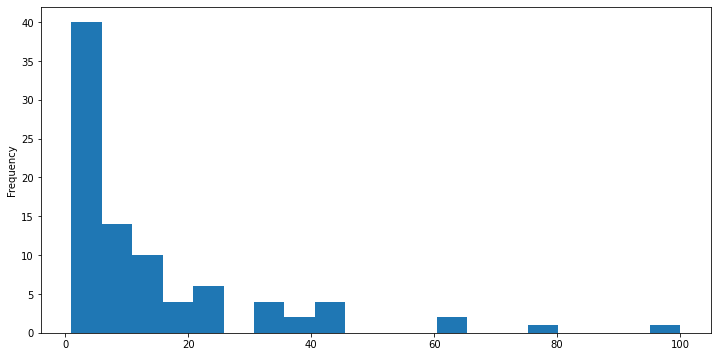

In [58]:
venue_counts.plot(kind='hist', bins=20, figsize=[12,6])

Let's check the same for venue categories as well.

In [63]:
category_counts = df_venues.groupby('Venue Category')['Venue'].count().sort_values(ascending=False)
print('Total number of rows is', category_counts.count())
print('Number of rows with < 5 venues is', category_counts.where(category_counts < 5).count())

Total number of rows is 240
Number of rows with < 5 venues is 172


<AxesSubplot:ylabel='Frequency'>

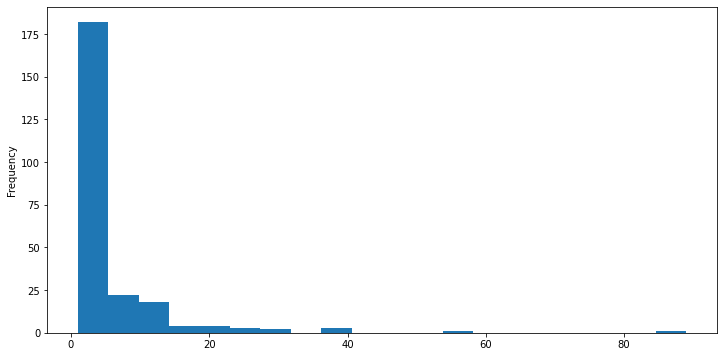

In [59]:
category_counts.plot(kind='hist', bins=20, figsize=[12,6])

We can see here that this data set is not very good for clustering. Most of the postal codes have very few datapoints, and there are too many categories with very few occurrences, perhaps suggesting that they need to be consolidated into broader categories.

In [99]:
# Create list of colors to use for mapping
cmap = cm.get_cmap(name='winter')
minc = venue_counts.min()
maxc = venue_counts.max()
color_list = []
for i in venue_counts:
    scaled_count = (i-minc)/(maxc-minc)
    color_list.append(colors.rgb2hex(cmap(scaled_count)))
color_list[0:5]

['#00ff80', '#00c49d', '#00a0af', '#00a0af', '#0071c6']

In [102]:
# Create map centred on Toronto
map_centre = [43.715383, -79.405678]
toronto_map = folium.Map(location=map_centre, zoom_start=11)

search_radius = 500 # Radius in metres

# Draw circles at each location is dataframe
for postal_code, color, count in zip(venue_counts.index, color_list, venue_counts):
    latitude = df_trim.loc[postal_code]['Latitude']
    longitude = df_trim.loc[postal_code]['Longitude']
    folium.Circle(
        [latitude, longitude],
        radius = search_radius,
        popup = postal_code + ' - ' + str(count),
        fill = False,
        color = color,
    ).add_to(toronto_map)

toronto_map # View map

The map above provides a visualization of the same issue. We see that only a small cluster of points near the centre have a sizable number of venues, the rest have very few datapoints.